<h1 align="center">Zero-Shot Text Classification with Hugging Face</h1>

Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

<font color="orange">Este Script é sobre como detectar o sentimento do texto de forma não-supervisionada, usando o modelo de classificação de texto Hugging Face zero-shot.</font> (zero-shot Pipeline sentiment)


 Estava estudando como detectar o sentimento do texto de maneira não-supervisionada. Mais especificamente, tratava-se da extração de dados. Com base em alguns tópicos predefinidos, minha tarefa era automatizar a extração de informações de dados de texto. Enquanto fazia pesquisas e verificava as melhores maneiras de resolver esse problema, descobri que o `Hugging Face NLP` oferece suporte à `classificação de texto zero-shot`.


<font color="red">O que é classificação de texto zero-shot?</font> 

Confira este post — [Zero-Shot Learning in Modern NLP](https://joeddav.github.io/blog/2020/05/29/ZSL.html). Há uma [demonstração](https://huggingface.co/spaces/joeddav/zero-shot-demo) ao vivo da equipe Hugging Face, juntamente com um [notebook Colab](https://colab.research.google.com/drive/1jocViLorbwWIkTXKwxCOV9HLTaDDgCaw) de amostra . <font color="pink">Em palavras simples, o modelo zero-shot nos permite classificar os dados, que não foram usados ​​para construir um modelo.</font> O que quero dizer aqui - o modelo foi construído por outra pessoa, estamos usando-o para executar em nossos dados.



Achei que seria um exemplo útil, onde busco mensagens do `Twitter` e executo a classificação para agrupar as mensagens em tópicos. Isso pode ser usado como ponto de partida para casos de uso mais complexos.


<font color="orange">Estou usando a biblioteca `GetOldTweets3` para descartar mensagens do Twitter. A `classificação zero-shot` com Transformers é direta, eu estava seguindo o exemplo do Colab fornecido pelo Hugging Face.</font>

# Importamos as Bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install langdetect


In [22]:
import csv
import re
import time
import traceback
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup
from langdetect import detect
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import argmax

from transformers import pipeline

<font color="orange">Instanciamos o classificador do Pipeline do Transformers:</font>

In [23]:
classifier = pipeline("zero-shot-classification", device=0) # to utilize GPU


No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Eu raspo 500 mensagens mais recentes do Twitter, com base em uma consulta predefinida – `“luta climática”`. Vamos buscar mensagens relacionadas à luta contra as mudanças climáticas no quadro de dados do Pandas e, em seguida, tentar dividi-las em tópicos usando a classificação zero-shot:

```
txt = 'climate fight'
max_recs = 500

tweets_df = text_query_to_df(txt, max_recs)
```

In [25]:
debug_mode = True
visited_websites = []
MAX_ROWS = 100
cur_no_rows = 0
LANGUAGE = "en"

# defining the googleSearch function
def googleSearch(query):
    # making the url ready for requests
    url = 'https://www.google.com/search?num=100&client=ubuntu&q={}&ie=utf-8&oe=utf-8'.format(query);
    # generating a random user agent using the randomAgent function we previously defined
    user_agent = "Mozilla/5.0 (X11; Linux x86_64; rv:2.0b9pre) Gecko/20110111 Firefox/4.0b9pre"
    print("user agent", user_agent)
    # defining header for the request function
    ran_head = {
        'user-agent': user_agent
    }
	  # declaring list g_clean to store the fetched urls
    g_clean = []
    # exception handling code to make sure we don't run into errors
    try:
        # fetching the response using get method in requests
        html = requests.get(url)
        # checking the response status to be success
        if html.status_code == 200:
            # parsing the fetched html in the response using lxml parser in beautiful soup
            soup = BeautifulSoup(html.text, 'lxml')

            # finding all the 'a' tags, links, in the parsed html
            a = soup.find_all('a')
            # looping through the all found a tags for processing
            for i in a:
                # extracting the href attribute for the link to the search results
                k = i.get('href')
                # exception handling code to prevent running into erros
                try:
                    # search for the pattern of a url to prevent unnecessary attributes in the result using re module
                    m = re.search("(?P<url>https?://[^\s]+)", k)
                    # fetching only the url part in the array
                    n = m.group(0)
                    # splitting the url upto the parameters part to get only the necessary url
                    rul = n.split('&')[0]
                    # parsing the url to divide it into components using urlparse
                    domain = urlparse(rul)
                    # checking if the fetched url belongs to google.com if true skip the url
                    if (re.search('google.com', domain.netloc)):
                        continue
                    # else add it to the result list
                    else:
                        g_clean.append(rul)
                except:
                    continue
    except Exception as ex:

        print(traceback.format_exc())
    # finally return the result urls
    finally:
        return g_clean


# grabs the title the headers information from a certain URL
def scrapHTML(url, writer, level=0):
    if("twitter.com" in url):
        print("skipping", url)
        return
    if("youtube.com" in url):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'pdf'):
        print("skipping", url)
        return
    if("pdf" in url):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'jpg'):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'jpeg'):
        print("skipping", url)
        return
    if (url[-3:].lower() == 'png'):
        print("skipping", url)
        return
    if ("download" in url):
        print("skipping", url)
        return
    if ("file" in url):
        print("skipping", url)
        return

    #making sure the website is not scrapped twice
    if url in visited_websites:
        return
    visited_websites.append(url)

    print(url, level)
    # exception handling code to make sure we don't run into errors
    try:
        # fetching the response using get method in requests
        if debug_mode:
            print("............start processing ", url)
        headers =  {
            "User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"
        }
        html = requests.get(url, headers=headers, timeout=10)
        # checking the response status to be success
        soup =  None
        if html.status_code == 200:
            # parsing the fetched html in the response using lxml parser in beautiful soup
            soup = BeautifulSoup(html.content, 'lxml')
            soup.encode("utf-8")
            soup.prettify('utf-8')
            span = soup.find_all('span', limit=300)
            # looping through the all found a tags for processing
            for i in span:
                try:
                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                       content = i.get_text(strip=False)
                       if (content.startswith("%PDF-")):
                           print("skipping PDF content", url)
                           return
                       write_content(content, writer, url, level)
                except Exception as exParse:
                    if debug_mode:
                       print("herror on span parsing", exParse)
                    continue

            if debug_mode:
                print("............Step 6 - span extraction : done!")

            p = soup.find_all('p', limit=300)
            # looping through the all found a tags for processing
            for i in p:
                try:
                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                        content = i.get_text(strip=False)
                        if(content.startswith("%PDF-")) :
                           print("skipping PDF content", url)
                           return
                        write_content(content, writer, url, level)
                except Exception as exParse:
                    if debug_mode:
                        print("herror on p parsing", exParse)
                    continue

            if debug_mode:
                print("............Step 7 - p extraction : done!")

            divs = soup.find_all('div', limit=300)
            # looping through the all found a tags for processing
            for i in divs:
                try:

                    hasChildren = False
                    for child in i.descendants:
                        if (child.name == 'p' or child.name == 'span' or child.name == 'div'):
                            hasChildren = True
                            break

                    if not hasChildren:
                        content = i.get_text(strip=False)
                        if(content.startswith("%PDF-")) :
                            print("skipping PDF content", url)
                            return
                        write_content(content, writer, url, level)

                except Exception as exParse:
                    if debug_mode:
                        print("herror on div parsing", exParse, url, content)
                        print(traceback.format_exc())
                    continue
            if debug_mode:
                print("............Step 8 - div extraction : done!")

            # only go on second level if wikipedia
            if level == 0 and not ("wikipedia.org" in url):
                return

                # only visit wikipedia pages in the required language
            if level == 1 and not (("https://" + LANGUAGE) in url):
                return

            if level == 0:
                # finding all the 'a' tags, links, in the parsed html
                a = soup.find_all('a')
                # looping through the all found a tags for processing
                for i in a:
                    # extracting the href attribute for the link to the search results
                    k = i.get('href')
                    # exception handling code to prevent running into erros
                    try:
                        # search for the pattern of a url to prevent unnecessary attributes in the result using re module
                        m = re.search("(?P<url>https?://[^\s]+)", k)
                        # fetching only the url part in the array
                        n = m.group(0)
                        # splitting the url upto the parameters part to get only the necessary url
                        rul = n.split('&')[0]
                        # parsing the url to divide it into components using urlparse
                        domain = urlparse(rul)
                        # checking if the fetched url belongs to google.com if true skip the url
                        if (re.search('google.com', domain.netloc)):
                            continue
                        # else add it to the result list
                        else:
                            if not(check_same_domain(url, rul)) :
                                scrapHTML(rul, writer, 1)
                    except Exception as ex:
                        continue

    except Exception as ex:
       if debug_mode:
          print(ex)
          print(traceback.format_exc())

def get_csv_file_name(text_query):
    return '/content/google_results.csv'

def check_same_domain(url, other_url):
    #remove the protocol
    url = url.replace("https://", "")

    cut_here = url.find("/")
    if cut_here == -1:
        cut_here = url.find("?")

    if(cut_here > 0):
        url = url[0:cut_here]

    result = False
    if url in other_url:
        result = True

    return result


# writes the text into the csv file
def write_content(content, writer, url, level):
    # remove links from text
    content = re.sub(r'^https?:\/\/.*[\r\n]*', '', content, flags=re.MULTILINE)

    # if a longer phrase
    if len(content) > 150 and detect(content) == LANGUAGE:
        content = content.replace('\n', ' ').replace('\r', ' ')
        writer.writerow({'content': content.strip(), 'url': url, 'type': 'content', 'level': level})

        

In [ ]:
# Calling search function
text_query = 'climate fight history'

startTime = time.time()
googleResults = googleSearch(text_query)
with open(get_csv_file_name(text_query), 'w', newline='', encoding="utf-8") as file:
    fieldnames = ['content', 'url', 'type', 'level']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    for resultURL in googleResults:
        url_content= scrapHTML(resultURL, writer)

duration = time.time() - startTime
print(duration)


In [28]:
#df = pd.read_csv('/content/google_results.csv', usecols=['content'], nrows=50)
df = pd.read_csv('/content/google_results.csv', usecols=['content'])
df.head(10)


,content
0,In the midst of the current international deba...
1,The UN Chronicle is not an official record. It...
2,"While United Nations police, justice and corre..."
3,How will we tackle today’s daunting challenges...
4,"Pulses have a broad genetic diversity, from wh..."
5,Peter Jackson is Chief Editor of the Yearbook ...
6,Documents and publications Yearbook of the U...
7,Libraries and Archives Dag Hammarskjöld Libr...
8,The UN at Work 17 Goals to Transform Our Wor...
9,1712 - British ironmonger Thomas Newcomen inve...


In [29]:
df.shape

(3963, 1)

In [30]:
for sent in df['content'].values:
  print(sent)
  print()

A saída de streaming foi truncada nas últimas 5000 linhas.
Many other issues may have seemed more pressing, or simply better understood. As Lienke writes in Struggling for Air, “At a time when Americans were still dying somewhat regularly in acute, inversion-related pollution episodes, it is unsurprising that legislators were more concerned with the known harms of sulfur dioxide and carbon monoxide than the uncertain, seemingly distant threat of climate change.”

That public statement, released later that month, emphasized the importance of shifting away from fossil fuel energy and highlighted the urgency of starting to transition to new energy sources as soon as possible: “With the end of the oil age in sight, we must make long-term decisions as to future energy policies. One lesson we have been learning is that the time required for transition from one major source to another is several decades.”

So what happened? When Press’s memo made it to the president’s desk, James “Jim” Schles

Na classificação zero-shot, você pode definir seus próprios rótulos e, em seguida, executar o classificador para atribuir uma probabilidade a cada rótulo. Existe a opção de fazer classificação multi-classe também, neste caso, as notas serão independentes, cada uma ficará entre 0 e 1. Vou usar a opção padrão, quando o pipeline assumir que apenas um dos candidatos labels é verdadeiro, retornando uma lista de pontuações para cada rótulo que soma $1$.


Rótulos de candidatos para tópicos - isso nos permitiria entender o que as pessoas realmente estão falando sobre a luta contra as mudanças climáticas. Algumas mensagens são simples anúncios, gostaríamos de ignorá-los. A classificação zero-shot é capaz de detectar anúncios muito bem, isso ajuda a limpar os dados:

```
candidate_labels = [ "renovável" , "política" , "emissão" , "temperatura" , "emergência" , "anúncio" ]
```

In [ ]:
candidate_labels = ["renewable", "politics", "emission", "temperature", "emergency", "advertisment"]
candidate_results = [0, 0, 0, 0, 0, 0]

for sent in df['content'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels)

    SCORES = res["scores"]
    CLASSES = res["labels"]
    BEST_INDEX = argmax(SCORES)
    predicted_class = CLASSES[BEST_INDEX]
    predicted_score = SCORES[BEST_INDEX]

    if predicted_class == 'renewable' and predicted_score > 0.5:
        candidate_results[0] = candidate_results[0] + 1
    if predicted_class == 'politics' and predicted_score > 0.5:
        candidate_results[1] = candidate_results[1] + 1
    if predicted_class == 'emission' and predicted_score > 0.5:
        candidate_results[2] = candidate_results[2] + 1
    if predicted_class == 'temperature' and predicted_score > 0.5:
        candidate_results[3] = candidate_results[3] + 1
    if predicted_class == 'emergency' and predicted_score > 0.5:
        candidate_results[4] = candidate_results[4] + 1
    if predicted_class == 'advertisment' and predicted_score > 0.5:
        candidate_results[5] = candidate_results[5] + 1

    if res['scores'][0] > 0.5:
        print(sent)
        print(res['labels'])
        print(res['scores'])
        print()

print(candidate_results)


In [33]:
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)


,labels,values
0,renewable,38
1,politics,11
2,emission,57
3,temperature,67
4,emergency,12
5,advertisment,12


<AxesSubplot:xlabel='labels', ylabel='values'>

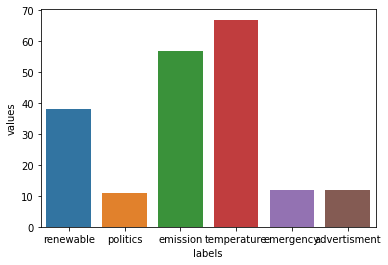

In [34]:
sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )


In [ ]:
candidate_labels = ["renewable", "politics", "emission", "temperature", "emergency", "advertisment"]
candidate_results = [0, 0, 0, 0, 0, 0]

for sent in df['content'].values:
    # To do multi-class classification, simply pass multi_class=True.
    # In this case, the scores will be independent, but each will fall between 0 and 1.
    res = classifier(sent, candidate_labels, multi_class=True)

    print_flag = 0
    for index, score in enumerate(res['scores']):
      if score > 0.5:
        if res['labels'][index] == 'renewable':
          candidate_results[0] = candidate_results[0] + 1
        if res['labels'][index] == 'politics':
          candidate_results[1] = candidate_results[1] + 1
        if res['labels'][index] == 'emission':
          candidate_results[2] = candidate_results[2] + 1
        if res['labels'][index] == 'temperature':
          candidate_results[3] = candidate_results[3] + 1
        if res['labels'][index] == 'emergency':
          candidate_results[4] = candidate_results[4] + 1
        if res['labels'][index] == 'advertisment':
          candidate_results[5] = candidate_results[5] + 1
        
        if print_flag == 0:
          print(sent)
          print(res['labels'])
          print(res['scores'])
          print()
          print_flag = 1

print(candidate_results)


In [37]:
data = {'labels': candidate_labels,
        'values': candidate_results}

df_chart = pd.DataFrame(data, columns=['labels','values'])

df_chart.head(10)

,labels,values
0,renewable,2
1,politics,1
2,emission,2
3,temperature,2
4,emergency,1
5,advertisment,1


<AxesSubplot:xlabel='labels', ylabel='values'>

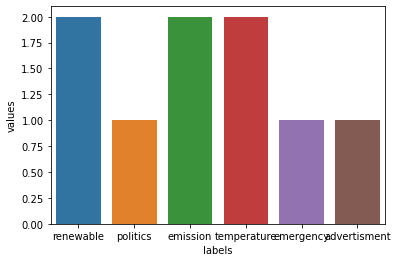

In [38]:
sns.barplot(data = df_chart
            ,x = 'labels'
            ,y = 'values'
            )

Vou entrar no loop e classificar cada mensagem:

```
res = classifier(sent, candidate_labels)
```


Então estou verificando o resultado da classificação. Basta verificar o primeiro rótulo, pois estou usando a opção padrão quando o pipeline assume que apenas um dos rótulos candidatos é verdadeiro. Se a pontuação da classificação for maior que $0.5$, estou registrando para processamento posterior:

```
if res['labels'][0] == 'renewable' and res['scores'][0] > 0.5:
    candidate_results[0] = candidate_results[0] + 1
```

A partir do resultado, podemos ver que o tema político domina a discussão da luta contra as mudanças climáticas, talvez como esperado. Tópicos relacionados a emissão e emergência são próximos uns dos outros pela popularidade. Houve cerca de `20` casos de anúncios de $500$ mensagens descartadas:

<font color="pink">Conclusão:</font>

A classificação de texto não-supervisionada com `modelo zero-shot` nos permite resolver tarefas de detecção de sentimento de texto quando você não tem dados de treinamento para treinar o modelo. Em vez disso, você conta com um grande modelo treinado de `Transformers`. Para casos de uso especializados, quando o texto é baseado em `palavras` ou `termos` específicos, é melhor usar um `modelo de classificação supervisionado`, com base no conjunto de treinamento. <font color="orange">Mas para tópicos gerais, o modelo zero-shot funciona incrivelmente bem.</font>